## Imports

In [1]:
# To embed plots in the notebooks
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np # numpy library
import scipy.linalg as lng # linear algebra from scipy library
from sklearn import preprocessing as preproc # load preprocessing function

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

## Load dataset

In [2]:
prostatePath = 'Prostate.txt'

T = np.loadtxt(prostatePath, delimiter = ' ', skiprows = 1, usecols=[1,2,3,4,5,6,7,8,9])

y = T[:, 0]
X = T[:,1:]

[n, p] = np.shape(X)

#Our chosen normalization centers and normalize the variables of a data matrix to unit length.
# We can use sklearn "Normalizer" to do this, but we must transpose the matrices to act on the variables instead of samples
X_pre = X - np.mean(X,axis=0)
y_pre = y - np.mean(y,axis=0)

normalizer = preproc.Normalizer().fit(X_pre.T)  
X_pre = normalizer.transform(X_pre.T).T

## 1 Perform model selection for ridge regression (for the prostate data set):
> (a) Consider using ridge-regression solutions for the prostate data set. What is a suitable range for the shrinkage parameter $λ$ in which to search for an optimal solution in?

In [3]:
def ridgeMulti(X, _lambda, p, y):
    """Ridge implementation from last week"""
    inner_prod = np.linalg.inv(np.matmul(X.T, X) + _lambda * np.eye(p,p))
    outer_prod = np.matmul(X.T, y)
    betas = np.matmul(inner_prod, outer_prod)
    return betas

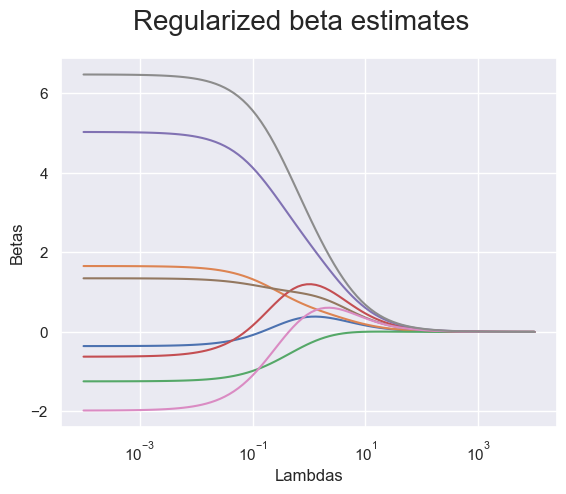

In [61]:
k = 100; # try k values of lambda
lambdas = np.logspace(-4, 4, k)

betas = np.zeros((p,k))

for i in range(k):
    betas[:,i] = ridgeMulti(X_pre, lambdas[i], p, y_pre)
    

    
plt.figure()
plt.semilogx(lambdas, betas.T )
plt.xlabel("Lambdas")
plt.ylabel("Betas")
plt.suptitle("Regularized beta estimates", fontsize=20)
plt.show()

What is a suitable range for $λ$ in which to search for an optimal solution?

> (b) Select a suitable value for the regularization parameter using K-fold cross-validation. Plot the resulting optimal value of lambda on a plot of the parameter trace (i.e. a plot of the $\hat{β}_j$s as a function of $λ$).

>> (i) Try one of the common choices K = 5 and K = 10, and run the cross- validation a couple of times. Which would you prefer and why?
*Hint: To do Crossvalidation create a vector of length n that contains equal amounts of numbers from 1 to K and permute that vector.*

In [59]:
def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

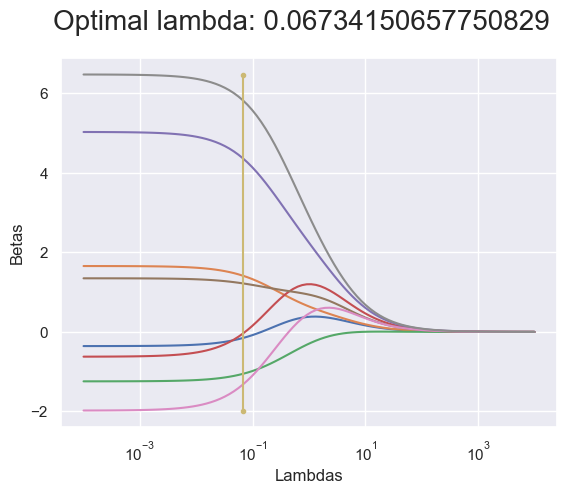

In [84]:
K = 10
lambdas = np.logspace(-4, 4, k)
MSE = np.zeros((10, 100))

#Create a vector of length n that contains equal amounts of numbers from 1 to K
toK = np.sort(np.arange(1,97+1,1)%10+1)
#Permute that vector. 
perm = np.random.permutation(toK)

# For each chunk of data; run ridge for each lambda and calculate mean squared error
for i in range(1, K+1):
    # split the data into 10 chunks
    X_train = X_pre[perm != i, :]
    y_train = y_pre[perm != i]
    X_test = X_pre[perm == i, :]
    y_test = y_pre[perm == i]
    # center the data
    X_train, mu = centerData(X_train)
    X_test = X_test - mu
    # calculate mean squared error for each lambda
    for j in range(k):
        beta = ridgeMulti(X_train, lambdas[j], p, y_train)
        y_pred = np.matmul(X_test, beta)
        MSE[i-1, j] = np.mean((y_test - y_pred)**2)

# average the mean squared error across chunks for the same lambda values to find the optimal lambda    
MSE_avg = np.mean(MSE, axis=0)
lambda_OP = lambdas[np.argmin(MSE_avg)]
# Remember excact solution depends on a random indexing, so results may vary
# I reuse the plot with all the betas from 1 a) and add a line for the optimal value of lambda
plt.figure()
plt.semilogx(lambdas, betas.T )
plt.xlabel("Lambdas")
plt.ylabel("Betas")
plt.suptitle(f"Optimal lambda: {lambda_OP}", fontsize=20)
plt.semilogx([lambda_OP, lambda_OP], [np.min(betas), np.max(betas)], marker = ".")
plt.show()

Where should you normalize your data?

(ii) What is the value of K corresponding to leave-one-out cross-validation?

> (c) Find a suitable value of $λ$ using the one-standard-error rule. What is the difference between the two strategies (cross-validation and cross-validation with one- standard-error-rule)?

In [85]:
# Calculate the standard error for the best lambda, and find a the largest lambda with a MSE that is within
# the range of the optimal lambda +- the standard error.
stError = np.std(MSE, axis=0)/(len(MSE)**0.5)
idx = np.where(MSE_avg <= (np.min(MSE_avg) + stError[np.argmin(MSE_avg)]))
Lambda_CV_1StdRule = np.max(lambdas[idx])
print("CV lambda with 1-std-rule %0.2f" % Lambda_CV_1StdRule)

CV lambda with 1-std-rule 0.52


> (d) Select suitable values for the regularization parameter using the AIC and BIC criteria (cf. 7.5-7.7 in ESL). What are the advantages and disadvantages of using cross-validation vs. information criteria?

In [86]:
np.trace(betas)

10.317121847330048

In [99]:
D = np.zeros(100)
AIC = np.zeros(100)
BIC = np.zeros(100)

beta_ols, _, rnk, _ = lng.lstsq(X_pre, y_pre)

s = np.mean((y_pre - np.matmul(X_pre, beta_ols))**2)

# calculate the AIC and BIC for ridge regression for different lambdas
# pick the lambda based on the models with the lowest AIC and BIC

for i in range(100):
    beta = ridgeMulti(X_pre, lambdas[i], p, y_pre)
    y_pred = np.matmul(X_pre, beta)
    MSEs = np.mean((y_pre - y_pred)**2)
    D[i] = np.trace(X_pre @ np.linalg.inv(X_pre.T @ X_pre + lambdas[i]*np.eye(p)) @ X_pre.T)
    AIC[i] = MSEs + 2*D[i]*s/n
    BIC[i] = (MSEs + np.log(n)*D[i]*s/n) * (n/s)

jAIC = np.argmin(AIC)
jBIC = np.argmin(BIC)

print("AIC at %0.2f" % lambdas[jAIC])
print("BIC at %0.2f" % lambdas[jBIC])

AIC at 0.05
BIC at 0.14


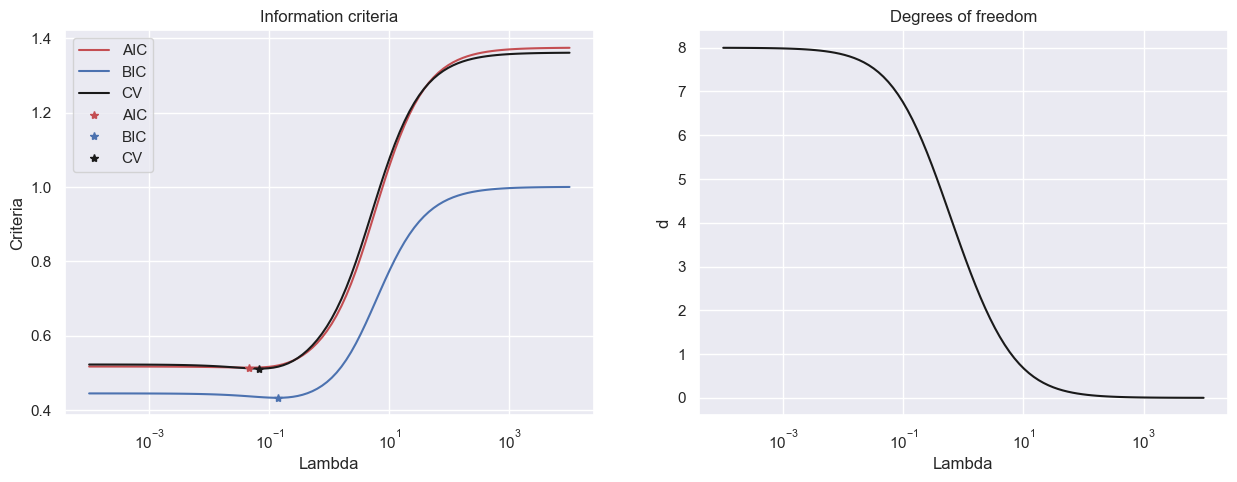

In [100]:
meanMSE = np.mean(MSE, axis=0)
jOpt = np.argmin(meanMSE)
#plot different methods Information criteria: AIC BIC CV
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].set_title('Information criteria')
_ = axs[0].semilogx(lambdas,AIC,'-r',label='AIC')
axs[0].semilogx(lambdas,BIC/300,'-b',label='BIC')
axs[0].semilogx(lambdas,meanMSE,'-k',label='CV')
axs[0].semilogx(lambdas[jAIC],np.min(AIC),'*r',label='AIC')
axs[0].semilogx(lambdas[jBIC],np.min(BIC)/300,'*b',label='BIC')
axs[0].semilogx(lambdas[jOpt],np.min(meanMSE),'*k',label='CV')
axs[0].legend()
axs[0].set_xlabel('Lambda')
axs[0].set_ylabel('Criteria')

#plot the degree of freedom
axs[1].semilogx(lambdas,D,'-k');
axs[1].set_title('Degrees of freedom');
axs[1].set_xlabel('Lambda');
axs[1].set_ylabel('d');

> (e) Use the bootstrap to estimate the variance of the parameters of the solution $(β)$ for each value of lambda in exercise 1a. Plot the variance estimates as a function of lambda. What do you notice?

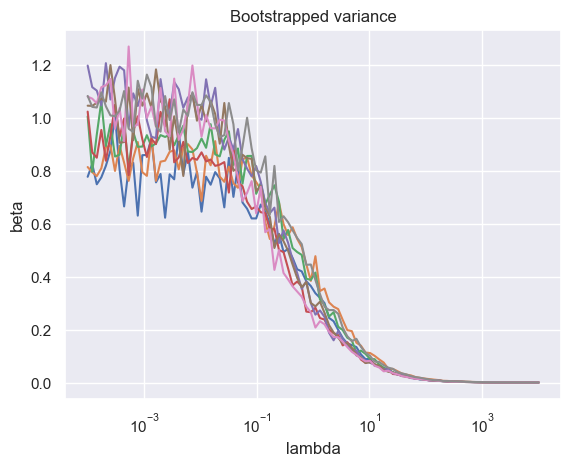

In [104]:
NBoot = 100
Beta = np.zeros((p, len(lambdas), NBoot))

# Run bootstrap on ridge for the same range of lambdas as before
# similarly as with cross validation you run the bootstrap x times and each time you sample with replacement
# ridge is then run on that sample for each lambda value

for i in range(len(lambdas)):
    for j in range(NBoot):
        idx = np.random.choice(n, n, replace=True)
        X_boot = X_pre[idx, :]
        y_boot = y_pre[idx]
        X_boot, mu = centerData(X_boot)
        y_boot = y_boot - np.mean(y_boot)
        Beta[:, i, j] = ridgeMulti(X_boot, lambdas[i], p, y_boot)

# Calculate the variance of the betas for each lambda value
stdBeta = np.std(Beta, axis=2)

# Plot the varriance of the betas for each lambda value
plt.figure()
for i in range(8):
    plt.semilogx(lambdas, stdBeta[i,:])
plt.title("Bootstrapped variance")
plt.ylabel("beta")
plt.xlabel("lambda")
plt.show()